In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

/home/fahad/anaconda3/envs/stu-perf-pred/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [5]:
df = pd.read_csv('data/stud.csv')

In [7]:
df.parental_level_of_education.unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

In [4]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [6]:
df.dtypes

gender                         object
race_ethnicity                 object
parental_level_of_education    object
lunch                          object
test_preparation_course        object
math_score                      int64
reading_score                   int64
writing_score                   int64
dtype: object

In [68]:
X = df.drop(columns='math_score')
y = df.math_score

In [49]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

In [51]:
ohe = OneHotEncoder()
std_scalar = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',ohe,cat_features),
        ('StandardScalar',std_scalar,num_features)
    ]
)

In [52]:
data = preprocessor.fit_transform(X)

In [56]:
data.shape

(1000, 19)

In [145]:
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.2)

In [ ]:
models = {
    'LinearRegression':{
        'model':LinearRegression(),
        'params':{},
    },
    'Lasso':{
        'model':Lasso(),
        'params':{
            'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            }
    },
    'Ridge':{
        'model':Ridge(),
        'params':{
            'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            }
    },
    'DecisionTreeRegressor':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[2, 3, 5, 7, 10, 15, 20, None] ,
            'max_features':[None,'sqrt']
        }
    },
    'RandomForestRegressor':{
        'model':RandomForestRegressor(),
        'params':{
            'n_estimators':[10, 50, 100, 150, 200, 300, 500],
        }
    },
    'AdaBoostRegressor':{
        'model':AdaBoostRegressor(),
        'params':{
            'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1,2]
        }
    },how to know hhow much size a df took
    'XGBRegressor':{
        'model':XGBRegressor(),
        'params':{}
    }
}

In [255]:
model_evals = []
for name,model in models.items():
    grid = GridSearchCV(
        estimator=model['model'],
        param_grid=model['params'],
        cv=10
    )

    grid.fit(X_train,y_train)

    best_model = {
        'model': name,
        'params' : grid.best_params_,   
        'score' : grid.best_score_,
        'estimator':grid.best_estimator_
    }
    model_evals.append(best_model)


In [256]:
best_models = pd.DataFrame(model_evals).sort_values(by='score',ascending=False)
best_models

,model,params,score,estimator
2,Ridge,{'alpha': 1},0.874200,Ridge(alpha=1)
1,Lasso,{'alpha': 0.01},0.874190,Lasso(alpha=0.01)
0,LinearRegression,{},0.874148,LinearRegression()
4,RandomForestRegressor,{'n_estimators': 300},0.843261,"(DecisionTreeRegressor(max_features=1.0, rando..."
5,AdaBoostRegressor,{'learning_rate': 2},0.837341,"(DecisionTreeRegressor(max_depth=3, random_sta..."
6,XGBRegressor,{},0.824120,"XGBRegressor(base_score=None, booster=None, ca..."
3,DecisionTreeRegressor,"{'max_depth': 5, 'max_features': None}",0.799032,DecisionTreeRegressor(max_depth=5)


- Linear models parforms better
- Ridge, Lasso and simple linear regression shows the best performance

In [262]:
model = best_models.iloc[0].estimator
model.fit(X_train,y_train)

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [207]:
model.score(X_test,y_test)

0.8456242898765951

In [208]:
y_pred = model.predict(X_test)

<Axes: xlabel='math_score'>

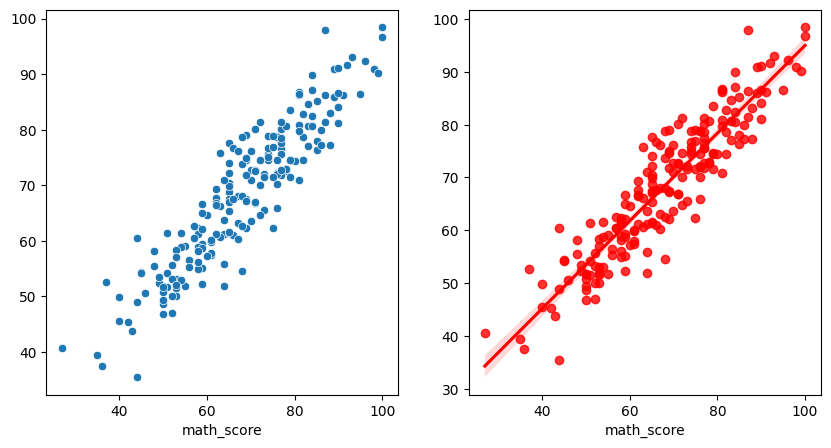

In [210]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=y_test,y=y_pred,ax=axes[0])
sns.regplot(x=y_test,y=y_pred,color ='red',ax=axes[1])

In [211]:
# Evaluate
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 4.481396553168252
RMSE: 5.5956100676274145
R2: 0.8456242898765951
